In [156]:
import plotly.graph_objs as go

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
pd.options.display.max_columns=None
pd.options.display.max_rows=None
pd.options.display.float_format = '{:.6f}'.format
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,auc,confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Train data

In [158]:
train=pd.read_csv("train.csv")
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [159]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78369 entries, 0 to 78368
Data columns (total 5 columns):
id                   78369 non-null int64
campaign_id          78369 non-null int64
coupon_id            78369 non-null int64
customer_id          78369 non-null int64
redemption_status    78369 non-null int64
dtypes: int64(5)
memory usage: 3.0 MB


In [160]:
train.shape

(78369, 5)

In [161]:
train.isnull().sum()

id                   0
campaign_id          0
coupon_id            0
customer_id          0
redemption_status    0
dtype: int64

In [162]:
train.nunique()

id                   78369
campaign_id             18
coupon_id              866
customer_id           1428
redemption_status        2
dtype: int64

#### Train_data features

 1. Campaign

In [163]:
# Unique campaign
sorted(train.campaign_id.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 26, 27, 28, 29, 30]

In [164]:
#Total unique campaign
train.campaign_id.nunique()

18

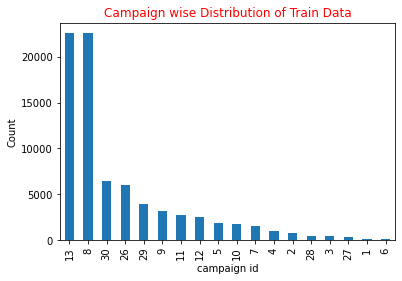

In [165]:
train.campaign_id.value_counts().plot(kind="bar")
plt.title("Campaign wise Distribution of Train Data",c='r')
plt.xlabel("campaign id")
plt.ylabel("Count")
plt.show()

In [166]:
# Campaign count in train data

2. coupon_id

In [167]:
# Total unique coupon id
train.coupon_id.nunique()

866

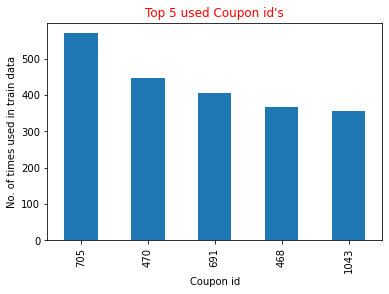

In [168]:
# Coupon_id 705 has the highest count in the train data (Top 5)
train.coupon_id.value_counts().head().plot(kind='bar')
plt.title("Top 5 used Coupon id's",c='r')
plt.xlabel('Coupon id')
plt.ylabel('No. of times used in train data')
plt.show()

3. customer_id 

In [169]:
# Total unique customers
train.customer_id.nunique()

1428

In [170]:
# Top 5 customers with maximum coupons (Top 5)
train.customer_id.value_counts().head()

1463    199
590     193
189     175
1192    173
464     171
Name: customer_id, dtype: int64

4. redemption_status 

In [171]:
train.redemption_status.value_counts()

0    77640
1      729
Name: redemption_status, dtype: int64

In [172]:
train.redemption_status.value_counts(normalize=True)*100

0   99.069785
1    0.930215
Name: redemption_status, dtype: float64

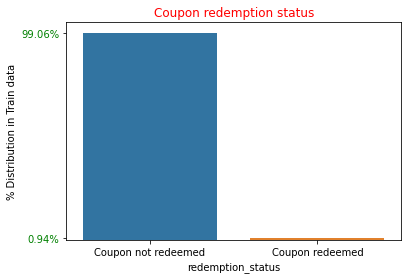

In [173]:
sns.countplot(train['redemption_status'])
#train.redemption_status.value_counts().plot(kind='bar')
plt.title("Coupon redemption status",c='r')
plt.yticks([train.redemption_status.value_counts()[0],train.redemption_status.value_counts()[1]],['99.06%','0.94%'],c='g')
plt.xticks([0,1],['Coupon not redeemed','Coupon redeemed'])
plt.ylabel('% Distribution in Train data')
plt.show()

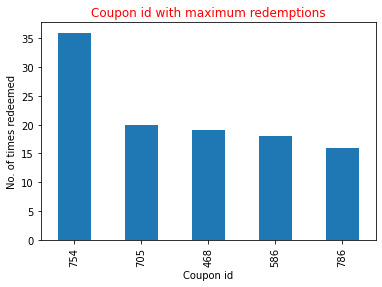

In [174]:
# Coupon_id with maximum redemption (Top 5)
train[train.redemption_status==1]["coupon_id"].value_counts().head().plot(kind='bar')
plt.title('Coupon id with maximum redemptions',c='r')
plt.xlabel("Coupon id")
plt.ylabel('No. of times redeemed')
plt.show()

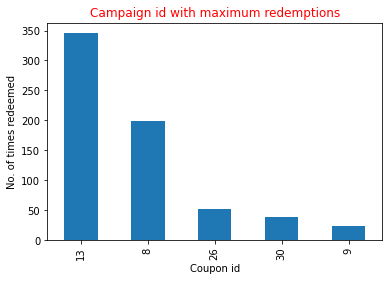

In [175]:
# Campaign_id with maximum redemption (Top 5)
train[train.redemption_status==1]["campaign_id"].value_counts().head().plot(kind='bar')
plt.title('Campaign id with maximum redemptions',c='r')
# campaign_id 13 is most successful campaign with 346 coupon redemption
plt.xlabel('Coupon id')
plt.ylabel('No. of times redeemed')
plt.show()

In [176]:
# All campaign are having some coupon redemtion
train[train.redemption_status==1]["campaign_id"].value_counts().count()

18

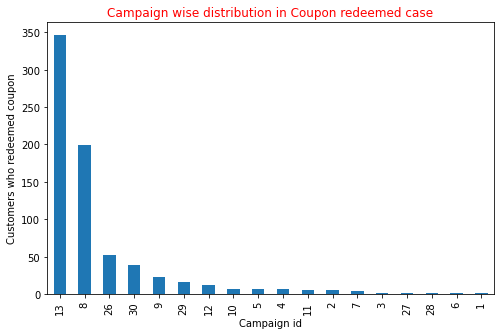

In [177]:
plt.figure(figsize=(8,5))
train[train.redemption_status==1]["campaign_id"].value_counts().plot(kind="bar")
plt.title("Campaign wise distribution in Coupon redeemed case",c='r')
plt.xlabel('Campaign id')
plt.ylabel("Customers who redeemed coupon")
plt.show()

In [178]:
# Customer with maximum redemption (Top 5)

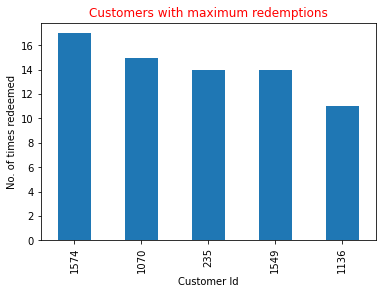

In [179]:
train[train.redemption_status==1]["customer_id"].value_counts().head().plot(kind='bar')
plt.title('Customers with maximum redemptions',c='r')
plt.xlabel('Customer Id')
plt.ylabel('No. of times redeemed')
plt.show()

In [180]:
# Total unique customers who redeemed coupon
train[train.redemption_status==1]["customer_id"].value_counts().count()

247

# Campaign data

In [181]:
campaign=pd.read_csv("campaign_data.csv")
campaign.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


In [182]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
campaign_id      28 non-null int64
campaign_type    28 non-null object
start_date       28 non-null object
end_date         28 non-null object
dtypes: int64(1), object(3)
memory usage: 1.0+ KB


In [183]:
# Converting start_date & end_date columns to datetime datatype
campaign.start_date=pd.to_datetime(campaign.start_date)
campaign.end_date=pd.to_datetime(campaign.end_date)

In [184]:
campaign["campaign_period"]=(campaign.end_date-campaign.start_date).dt.days
campaign["campaign_Year"]=campaign.start_date.dt.year
campaign["campaign_month"]=campaign.start_date.dt.month

In [185]:
def quarter(month,year):
    if (month in [1,2,3]) and (year == 2012):
        return 1
    elif (month in [4,5,6]) and (year == 2012):
        return 2
    elif (month in [7,8,9]) and (year == 2012):
        return 3
    elif (month in [10,11,12]) and (year == 2012):
        return 4
    elif (month in [1,2,3]) and (year == 2013):
        return 5
    elif (month in [4,5,6]) and (year == 2013):
        return 6
    elif (month in [7,8,9]) and (year == 2013):
        return 7
    elif (month in [10,11,12]) and (year == 2013):
        return 8

In [186]:
# Adding campaign_quarter feature
campaign["campaign_quarter"]=list(map(lambda x,y: quarter(x,y),campaign.campaign_month,campaign.campaign_Year))

In [187]:
campaign.head()

,campaign_id,campaign_type,start_date,end_date,campaign_period,campaign_Year,campaign_month,campaign_quarter
0,24,Y,2013-10-21,2013-12-20,60,2013,10,8
1,25,Y,2013-10-21,2013-11-22,32,2013,10,8
2,20,Y,2013-07-09,2013-11-16,130,2013,7,7
3,23,Y,2013-08-10,2013-11-15,97,2013,8,7
4,21,Y,2013-09-16,2013-10-18,32,2013,9,7


In [188]:
# Converting columns to object datatype
campaign["campaign_Year"]=campaign["campaign_Year"].astype("object")
campaign["campaign_month"]=campaign["campaign_month"].astype("object")

In [189]:
#campaign.drop(["start_date","end_date"],axis=1,inplace=True)

In [190]:
campaign.dtypes

campaign_id                  int64
campaign_type               object
start_date          datetime64[ns]
end_date            datetime64[ns]
campaign_period              int64
campaign_Year               object
campaign_month              object
campaign_quarter             int64
dtype: object

In [191]:
campaign.isnull().sum()

campaign_id         0
campaign_type       0
start_date          0
end_date            0
campaign_period     0
campaign_Year       0
campaign_month      0
campaign_quarter    0
dtype: int64

In [192]:
campaign.shape

(28, 8)

#### Campaign features

1. Campaign_id

In [193]:
# Number of campaign - 28
campaign.campaign_id.count()

28

In [194]:
A=set(train.campaign_id)
B=set(campaign.campaign_id)

In [195]:
A 

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 26, 27, 28, 29, 30}

In [196]:
D=list(B-A)
D

[16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

2. Campaign_type

In [197]:
campaign.campaign_type.value_counts()

Y    22
X     6
Name: campaign_type, dtype: int64

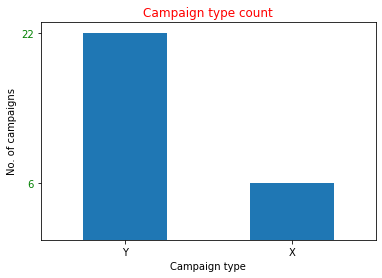

In [198]:
# Types of campaign
campaign.campaign_type.value_counts().plot(kind="bar")
plt.title('Campaign type count',c='r')
plt.yticks([22,6],c='g')
plt.ylabel('No. of campaigns')
plt.xlabel('Campaign type')
plt.xticks(rotation = 0)
plt.show()

3. Campaign_period

In [199]:
campaign.campaign_period.nunique()

20

In [200]:
campaign.campaign_period.unique()

array([  60,   32,  130,   97, -181,  -12,   75,   62,   31,   77,  182,
        -25,   56, -289,   37,  133,  112,   61,   63,  -78], dtype=int64)

In [201]:
# We can observe there are some error in data, as campaign period can't be negative

campaign[campaign.campaign_period<0]

,campaign_id,campaign_type,start_date,end_date,campaign_period,campaign_Year,campaign_month,campaign_quarter
6,18,X,2013-10-08,2013-04-10,-181,2013,10,8
10,13,X,2013-05-19,2013-05-07,-12,2013,5,6
17,6,Y,2013-01-28,2013-01-03,-25,2013,1,5
19,5,Y,2013-12-01,2013-02-15,-289,2013,12,8
27,26,X,2012-12-08,2012-09-21,-78,2012,12,4


In [202]:
# Campaign details related to train data (sorted wrt start_date)
campaign[(campaign.campaign_id.isin(A))].sort_values("start_date")

,campaign_id,campaign_type,start_date,end_date,campaign_period,campaign_Year,campaign_month,campaign_quarter
24,29,Y,2012-08-10,2012-11-30,112,2012,8,3
26,27,Y,2012-08-25,2012-10-27,63,2012,8,3
25,28,Y,2012-09-16,2012-11-16,61,2012,9,3
23,30,X,2012-11-19,2013-04-01,133,2012,11,4
27,26,X,2012-12-08,2012-09-21,-78,2012,12,4
21,1,Y,2012-12-12,2013-01-18,37,2012,12,4
22,2,Y,2012-12-17,2013-01-18,32,2012,12,4
18,3,Y,2012-12-22,2013-02-16,56,2012,12,4
17,6,Y,2013-01-28,2013-01-03,-25,2013,1,5
16,7,Y,2013-02-02,2013-08-03,182,2013,2,5


4. Campaign_year

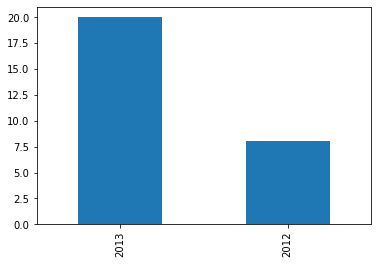

In [203]:
# No. of campaign per year
campaign.campaign_Year.value_counts().plot(kind="bar")
plt.show()

5. Campaign_month

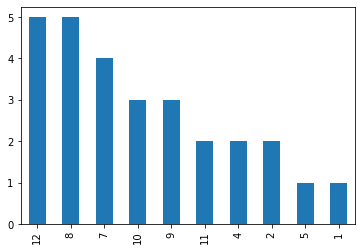

In [204]:
# No. of campaign in different months
campaign.campaign_month.value_counts().plot(kind="bar")
plt.show()

6. campaign_quarter

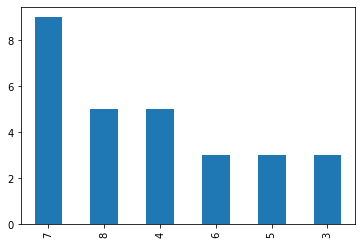

In [205]:
# Campaign in different quarters
campaign.campaign_quarter.value_counts().plot(kind="bar")
plt.show()

# Coupon_item_mapping data

In [206]:
coupon_item_mapping=pd.read_csv("coupon_item_mapping.csv")
coupon_item_mapping.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


In [207]:
coupon_item_mapping.shape

(92663, 2)

In [208]:
coupon_item_mapping.isnull().sum()

coupon_id    0
item_id      0
dtype: int64

In [209]:
coupon_item_mapping.nunique()

coupon_id     1116
item_id      36289
dtype: int64

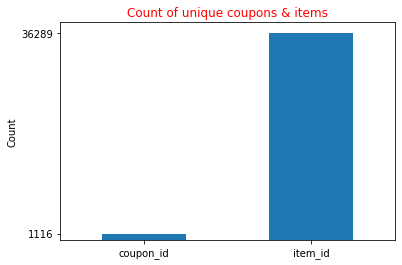

In [210]:
# No. of unique coupon_id and items
coupon_item_mapping.nunique().plot(kind='bar')
plt.title('Count of unique coupons & items',c='r')
plt.ylabel('Count')
plt.yticks([1116,36289])
plt.xticks(rotation=0)
plt.show()

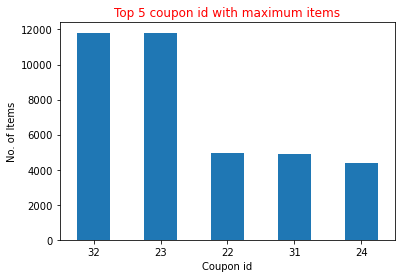

In [211]:
# Top 5 coupon_id with max items
coupon_item_mapping.groupby("coupon_id").item_id.agg("count").sort_values(ascending=False).head().plot(kind='bar')
plt.title('Top 5 coupon id with maximum items',c='r')
plt.xlabel('Coupon id')
plt.ylabel('No. of Items')
plt.xticks(rotation=0)
plt.show()

In [212]:
#checking each coupon have unique item or not
l1=list(coupon_item_mapping[coupon_item_mapping.coupon_id==32]["item_id"].unique())
l3=[]
for i in train.coupon_id.unique():
    l2=list(coupon_item_mapping[coupon_item_mapping.coupon_id==i]["item_id"].unique())
    c=0
    for  j in l2:
        if j in l1:
            c=c+1
    if c>0:
        l3.append(i)
print("Coupon_id which have same items as id no. 32",l3)


Coupon_id which have same items as id no. 32 [635, 517, 893, 689, 268, 278, 911, 663, 1114, 271, 256, 828, 24, 839, 658, 473, 627, 667, 1056, 279, 687, 275, 544, 490, 836, 996, 1044, 694, 968, 283, 734, 1057, 1018, 257, 641, 1045, 265, 912, 682, 733, 951, 293, 281, 280, 285, 284, 504, 986, 296, 26, 737, 954, 261, 740, 260, 249, 732, 852, 934, 937, 422, 1000, 502, 588, 979, 513, 23, 457, 25, 1108, 964, 1102, 292, 248, 579, 731, 516, 1099, 287, 474, 392, 276, 389, 455, 741, 735, 269, 1098, 273, 634, 691, 431, 666, 850, 738, 321, 244, 1105, 277, 1019, 692, 660, 967, 851, 15, 472, 662, 1090, 243, 406, 253, 471, 250, 550, 862, 998, 987, 5, 1092, 399, 391, 830, 829, 1101, 827, 665, 395, 1089, 400, 398, 626, 729, 739, 1082, 1093, 421, 838, 859, 965, 858, 963, 401, 282, 402, 831, 1095, 394, 1091, 263, 1088, 1097, 835, 291, 1096, 832, 393, 826, 264, 397, 837, 728]


In [213]:
x=set(coupon_item_mapping[coupon_item_mapping.coupon_id==635]["item_id"].unique())
y =set(coupon_item_mapping[coupon_item_mapping.coupon_id==32]["item_id"].unique())

inter=x.intersection(y)

# inter have items which is common between 32 and 635 coupon_id

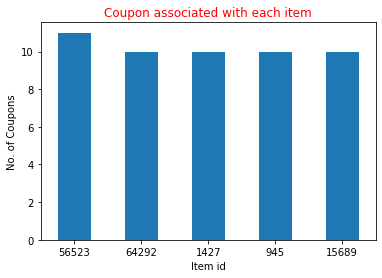

In [214]:
coupon_item_mapping.groupby("item_id")["coupon_id"].count().sort_values(ascending=False).head().plot(kind='bar')
plt.title('Coupon associated with each item',c='r')
plt.xticks(rotation=0)
plt.xlabel('Item id')
plt.ylabel('No. of Coupons')
plt.show()

In [215]:
# We can observe that each coupon_id doesn't have unique items

# customer_demographics data

In [216]:
customer_demographics=pd.read_csv("customer_demographics.csv")
customer_demographics.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [217]:
customer_demographics.shape

(760, 7)

In [218]:
customer_demographics.nunique()

customer_id       760
age_range           6
marital_status      2
rented              2
family_size         5
no_of_children      3
income_bracket     12
dtype: int64

In [219]:
customer_demographics.isnull().sum()

customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64

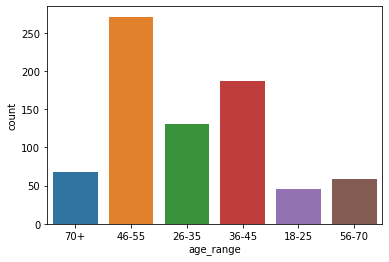

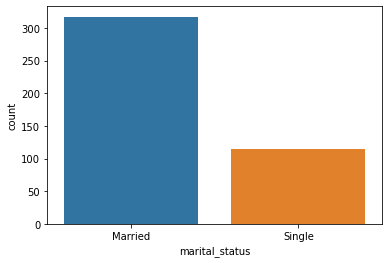

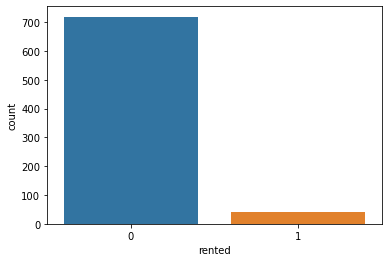

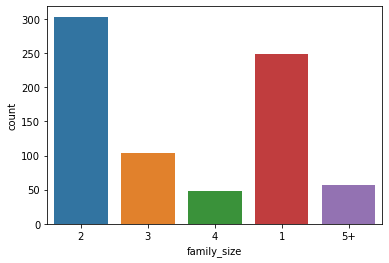

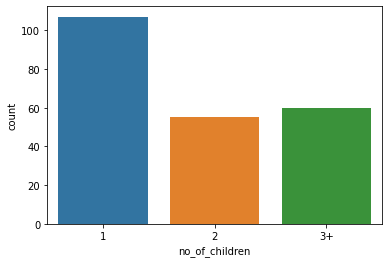

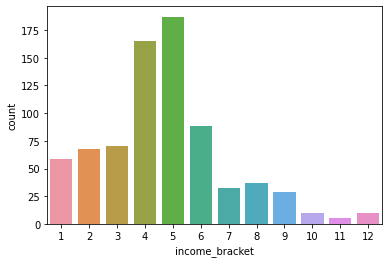

In [220]:
for i in customer_demographics.columns[1:]:
    sns.countplot(customer_demographics[i])
    plt.show()

In [221]:
train.customer_id.nunique()

1428

In [222]:
# There are total 1428 customers in train data but we only have dempgraphic details of 760 customers only.

# Item data

In [223]:
item=pd.read_csv("item_data.csv")
item.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [224]:
item.shape

(74066, 4)

In [225]:
item.nunique()

item_id       74066
brand          5528
brand_type        2
category         19
dtype: int64

In [226]:
item.isnull().sum()

item_id       0
brand         0
brand_type    0
category      0
dtype: int64

#### Item Features

1. item_id

In [227]:
# There are total 74066 items
item.item_id.count()

74066

2. brand 

In [228]:
# There are total 5528 unique brand
item.brand.nunique()

5528

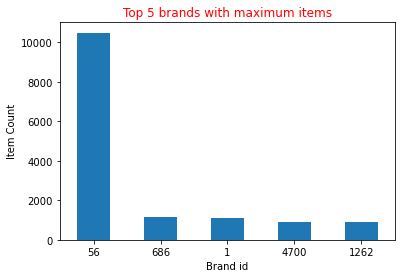

In [229]:
item['brand'].value_counts().head().plot(kind='bar')
plt.title('Top 5 brands with maximum items',c='r')
plt.ylabel('Item Count')
plt.xlabel('Brand id')
plt.xticks(rotation=0)
plt.show()

3. brand_type

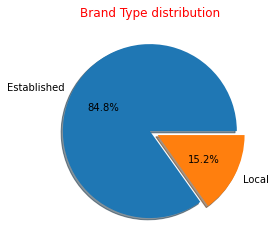

In [230]:
item.brand_type.value_counts().plot(kind="pie",autopct='%1.1f%%',explode=[0,0.1],shadow=True)
plt.title('Brand Type distribution',c='r')
plt.ylabel('')
plt.show()

4. Category

In [231]:
item.category.value_counts()

Grocery                   32448
Pharmaceutical            24471
Natural Products           2533
Dairy, Juices & Snacks     2425
Skin & Hair Care           2244
Meat                       2080
Packaged Meat              1966
Prepared Food              1880
Bakery                     1679
Seafood                     728
Flowers & Plants            664
Miscellaneous               385
Alcohol                     303
Garden                      102
Restauarant                  78
Salads                       40
Travel                       19
Fuel                         14
Vegetables (cut)              7
Name: category, dtype: int64

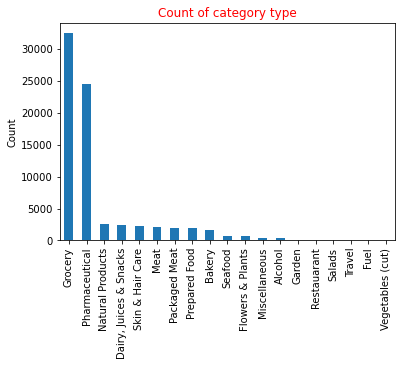

In [232]:
item.category.value_counts().plot(kind="bar")
plt.title('Count of category type',c='r')
plt.ylabel('Count')
plt.show()

In [233]:
# Clubbing differnt category 

In [234]:
fish_meat=["Meat","Packaged Meat","Seafood"]
dairy=["Dairy, Juices & Snacks","Prepared Food","Bakery","Salads","Vegetables (cut)"]
health=["Skin & Hair Care","Pharmaceutical","Natural Products"]
garden=["Flowers & Plants","Garden"]
misc=["Travel","Fuel","Restauarant","Alcohol"]

In [235]:
item["category"]=item["category"].apply(lambda x: "Meat & Fish" if x in fish_meat else x)
item["category"]=item["category"].apply(lambda x: "Food & Dairy" if x in dairy else x)
item["category"]=item["category"].apply(lambda x: "Health & Personal care" if x in health else x)
item["category"]=item["category"].apply(lambda x: "Garden" if x in garden else x)
item["category"]=item["category"].apply(lambda x: "Miscellaneous" if x in misc else x)

In [236]:
item["category"].value_counts()

Grocery                   32448
Health & Personal care    29248
Food & Dairy               6031
Meat & Fish                4774
Miscellaneous               799
Garden                      766
Name: category, dtype: int64

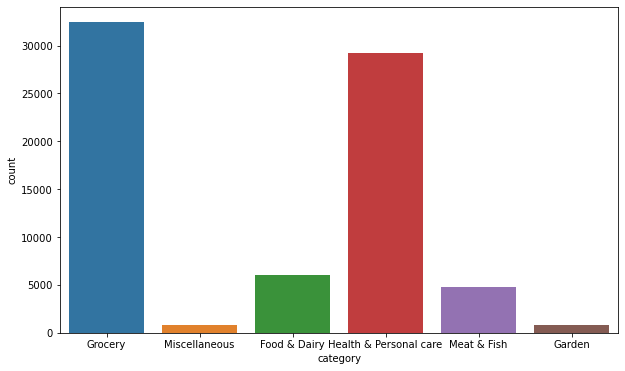

In [237]:
plt.figure(figsize=(10,6))
sns.countplot(item["category"])
plt.show()

# Customer Transaction data

In [238]:
cust_tran=pd.read_csv("customer_transaction_data.csv")
cust_tran.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.260000,-10.690000,0.000000
1,2012-01-02,1501,54253,1,53.430000,-13.890000,0.000000
2,2012-01-02,1501,31962,1,106.500000,-14.250000,0.000000
3,2012-01-02,1501,33647,1,67.320000,0.000000,0.000000
4,2012-01-02,1501,48199,1,71.240000,-28.140000,0.000000


In [239]:
cust_tran.shape

(1324566, 7)

In [240]:
cust_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
date               1324566 non-null object
customer_id        1324566 non-null int64
item_id            1324566 non-null int64
quantity           1324566 non-null int64
selling_price      1324566 non-null float64
other_discount     1324566 non-null float64
coupon_discount    1324566 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 70.7+ MB


In [241]:
cust_tran.describe()

,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
count,1324566.000000,1324566.000000,1324566.000000,1324566.000000,1324566.000000,1324566.000000
mean,804.001972,29519.030160,130.663340,114.603633,-17.768707,-0.594898
std,457.336313,17908.064406,1311.545447,152.905303,37.888674,7.069367
min,1.000000,1.000000,1.000000,0.360000,-3120.310000,-1992.230000
25%,418.000000,14684.000000,1.000000,49.160000,-23.150000,0.000000
50%,801.000000,26597.000000,1.000000,78.010000,-1.780000,0.000000
75%,1198.000000,42405.750000,1.000000,124.310000,0.000000,0.000000
max,1582.000000,74066.000000,89638.000000,17809.640000,0.000000,0.000000


In [242]:
cust_tran.nunique()

date                 549
customer_id         1582
item_id            74063
quantity            9252
selling_price       4923
other_discount      1418
coupon_discount      232
dtype: int64

In [243]:
cust_tran["date"]=pd.to_datetime(cust_tran["date"])

In [244]:
uniq=coupon_item_mapping.item_id.unique()
cust_tran['item_coupon']= list(map(lambda x : 1 if x in uniq else 0,cust_tran.item_id))

In [245]:
cust_tran['item_coupon'].head()

0    1
1    1
2    1
3    0
4    1
Name: item_coupon, dtype: int64

In [246]:
a=set(train.customer_id.unique())
b= set(cust_tran.customer_id.unique())

In [247]:
c=b-a

In [248]:
a-b

set()

In [249]:
len(c)

154

#### Transaction data feature

1. date 

In [250]:
min(cust_tran.date)

Timestamp('2012-01-02 00:00:00')

In [251]:
max(cust_tran.date)

Timestamp('2013-07-03 00:00:00')

2. customer_id 

In [252]:
# Total unique customer in transaction data
cust_tran.customer_id.nunique()

1582

In [253]:
# Total unique customer in train data
train.customer_id.nunique()

1428

3. item_id

In [254]:
# Item count (top 5)
cust_tran.item_id.value_counts().sort_values(ascending=False).head()

49009    13540
34047     6308
13174     3879
45502     3292
29847     2276
Name: item_id, dtype: int64

In [255]:
# Total unique item in transaction data
cust_tran.item_id.nunique()

74063

4. quantity

In [256]:
cust_tran.quantity.unique()

array([    1,     3,     2, ..., 15853, 21837, 19364], dtype=int64)

In [257]:
cust_tran.quantity.nunique()

9252

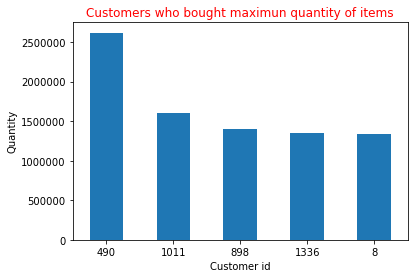

In [258]:
# Top 5 customers who brought maximum quantity of items
cust_tran.groupby("customer_id")["quantity"].sum().sort_values(ascending=False).head().plot(kind='bar')
plt.title('Customers who bought maximun quantity of items',c='r')
plt.yticks(style='normal')
plt.ticklabel_format(axis="y", style="plain")
plt.xticks(rotation=0)
plt.xlabel('Customer id')
plt.ylabel('Quantity')
plt.show()

In [259]:
# Top 5 items with maximum quantity 
cust_tran.groupby("item_id")["quantity"].sum().sort_values(ascending=False).head()

item_id
49009    147200033
48973      9829518
49004      9321734
49102      1678839
39453      1029216
Name: quantity, dtype: int64

5. selling_price

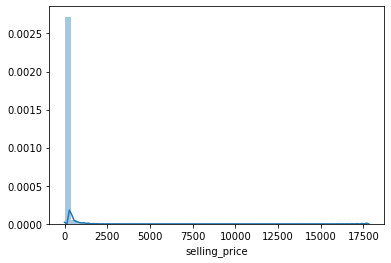

In [260]:
sns.distplot(cust_tran.selling_price)
plt.show()

In [261]:
# Maximum selling price
max(cust_tran.selling_price)

17809.64

In [262]:
# Minimum Selling price
min(cust_tran.selling_price)

0.36

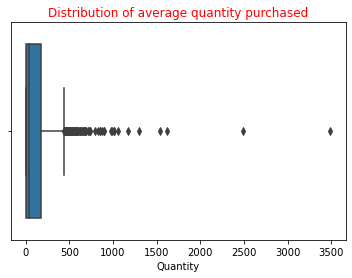

In [263]:
sns.boxplot(cust_tran.groupby('customer_id').mean()['quantity'])
plt.title('Distribution of average quantity purchased',c='r')
plt.xlabel('Quantity')
plt.show()

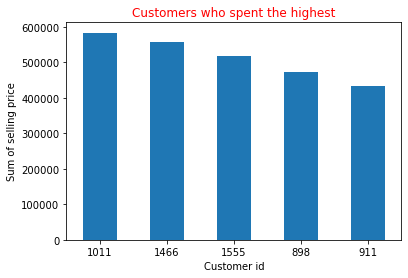

In [264]:
# Customer who spend highest in transaction data (not considering discount)
cust_tran.groupby("customer_id")["selling_price"].sum().sort_values(ascending=False).head().plot(kind='bar')
plt.title('Customers who spent the highest',c='r')
plt.ylabel('Sum of selling price')
plt.xlabel('Customer id')
plt.xticks(rotation=0)
plt.show()

6. other_discount

In [265]:
# No. of transaction with other discount
cust_tran[cust_tran.other_discount<0]["customer_id"].count()

671649

In [266]:
# No. of Unique Customer's who got other_discount
cust_tran[cust_tran.other_discount<0]["customer_id"].nunique()

1582

7.coupon_discount

In [267]:
# No. of transaction with coupon discount
cust_tran[cust_tran.coupon_discount<0]["customer_id"].count()

21286

In [268]:
# No. of Unique Customer's who got coupon_discount
cust_tran[cust_tran.coupon_discount<0]["customer_id"].nunique()

1249

8.item_coupon

In [269]:
cust_tran['item_coupon'].value_counts()

1    768432
0    556134
Name: item_coupon, dtype: int64

In [270]:
# Quantity brought by customer wrt date
cust_tran.groupby(["customer_id","date"])["quantity"].sum().head()

customer_id  date      
1            2012-02-21    31
             2012-03-08    13
             2012-03-29     9
             2012-04-04    28
             2012-04-11    17
Name: quantity, dtype: int64

In [271]:
cust_tran.groupby(["customer_id","date"])["quantity"].sum().shape

(142445,)

In [272]:
# Unique Item brought by customer wrt date
cust_tran.groupby(["customer_id","date"])["item_id"].nunique().head()

customer_id  date      
1            2012-02-21    27
             2012-03-08    10
             2012-03-29     8
             2012-04-04    19
             2012-04-11    14
Name: item_id, dtype: int64

In [273]:
data = cust_tran.groupby(["customer_id"]).mean()

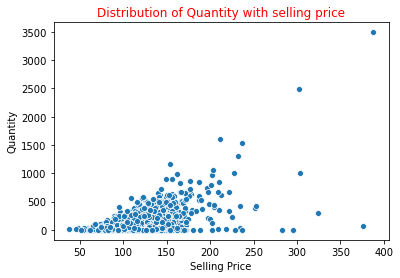

In [274]:
sns.scatterplot(data=data,y='quantity',x='selling_price')
plt.title('Distribution of Quantity with selling price',c='r')
plt.ylabel('Quantity')
plt.xlabel('Selling Price')
plt.show()

## Merging Data

In [275]:
train_campaign=pd.merge(train,campaign,how='left',on='campaign_id')

In [276]:
item_coupon_map=pd.merge(coupon_item_mapping,item,how="left",on="item_id")
item_coupon_map=pd.get_dummies(item_coupon_map,prefix="category_count",columns=["category","brand_type"])

In [277]:
brand_unique=item_coupon_map[["coupon_id","brand"]].groupby("coupon_id")["brand"].nunique().reset_index()
brand_unique.columns=["coupon_id",'coupon_unique_brand']
item_count=item_coupon_map[["coupon_id","item_id"]].groupby("coupon_id").agg("count").reset_index()
item_count.columns=["coupon_id","coupon_item_count"]
item_coupon_map=item_coupon_map.drop(["item_id","brand"],axis=1).groupby("coupon_id").agg("sum").reset_index()

In [278]:
item_coupon_map=pd.merge(item_coupon_map,item_count,how="inner",on="coupon_id")
item_coupon_map=pd.merge(item_coupon_map,brand_unique,how="inner",on="coupon_id")

In [279]:
train_camp_item_coupon_map=pd.merge(train_campaign,item_coupon_map,how="left",on="coupon_id")

In [280]:
item_count=cust_tran[["customer_id","item_id"]].groupby("customer_id").agg("count").reset_index()
item_count.columns=["customer_id","total_item_customer_purchased"]
frequency=cust_tran[["date","customer_id"]].groupby("customer_id")["date"].nunique().reset_index()
frequency.columns=["customer_id","buying_frequency"]
item_coupon=cust_tran[["item_coupon","customer_id"]].groupby("customer_id")["item_coupon"].sum().reset_index()
item_coupon.columns=["customer_id","items_with_coupon_count"]

In [281]:
cust_tran=cust_tran.drop(["date","item_id","item_coupon"],axis=1).groupby("customer_id").agg("mean").reset_index()
cust_tran.columns=['customer_id', 'mean_item_quantity_purchased', 'mean_selling_price', 'mean_other_discount','mean_coupon_discount']

In [282]:
cust_tran.mean_item_quantity_purchased=round(cust_tran.mean_item_quantity_purchased)

In [283]:
cust_tran=pd.merge(cust_tran,item_count,on="customer_id",how="inner")
cust_tran=pd.merge(cust_tran,frequency,on="customer_id",how="inner")
cust_tran=pd.merge(cust_tran,item_coupon,on="customer_id",how="inner")

In [284]:
df_final=pd.merge(train_camp_item_coupon_map,cust_tran,how="left",on="customer_id")

In [285]:
df_final.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,campaign_period,campaign_Year,campaign_month,campaign_quarter,category_count_Food & Dairy,category_count_Garden,category_count_Grocery,category_count_Health & Personal care,category_count_Meat & Fish,category_count_Miscellaneous,category_count_Established,category_count_Local,coupon_item_count,coupon_unique_brand,mean_item_quantity_purchased,mean_selling_price,mean_other_discount,mean_coupon_discount,total_item_customer_purchased,buying_frequency,items_with_coupon_count
0,1,13,27,1053,0,X,2013-05-19,2013-05-07,-12,2013,5,6,0.000000,0.000000,125.000000,0.000000,0.000000,0.000000,125.000000,0.000000,125,2,340.000000,184.260484,-33.168935,-0.287258,310,80,139
1,2,13,116,48,0,X,2013-05-19,2013-05-07,-12,2013,5,6,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3,1,32.000000,234.247013,-27.699169,-3.215039,385,64,210
2,6,9,635,205,0,Y,2013-11-03,2013-12-04,31,2013,11,8,0.000000,0.000000,0.000000,67.000000,0.000000,0.000000,67.000000,0.000000,67,1,1.000000,121.094495,-17.795660,-2.212082,970,83,652
3,7,13,644,1050,0,X,2013-05-19,2013-05-07,-12,2013,5,6,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,4.000000,0.000000,4,1,1.000000,98.276034,-16.655570,-0.751477,237,64,128
4,9,8,1017,1489,0,X,2013-02-16,2013-05-04,77,2013,2,5,0.000000,0.000000,32.000000,0.000000,0.000000,0.000000,32.000000,0.000000,32,1,247.000000,120.636103,-20.524733,-0.471548,562,97,283


In [286]:
df_final.shape

(78369, 29)

In [287]:
#pd.to_datetime(campaign.start_date,format="%d/%m/%y")
#pd.to_datetime(campaign.end_date,format="%d/%m/%y")

In [288]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Data columns (total 29 columns):
id                                       78369 non-null int64
campaign_id                              78369 non-null int64
coupon_id                                78369 non-null int64
customer_id                              78369 non-null int64
redemption_status                        78369 non-null int64
campaign_type                            78369 non-null object
start_date                               78369 non-null datetime64[ns]
end_date                                 78369 non-null datetime64[ns]
campaign_period                          78369 non-null int64
campaign_Year                            78369 non-null object
campaign_month                           78369 non-null object
campaign_quarter                         78369 non-null int64
category_count_Food & Dairy              78369 non-null float64
category_count_Garden                    78369 non-null float6

### Checking null values

In [289]:
df_final.isnull().sum()

id                                       0
campaign_id                              0
coupon_id                                0
customer_id                              0
redemption_status                        0
campaign_type                            0
start_date                               0
end_date                                 0
campaign_period                          0
campaign_Year                            0
campaign_month                           0
campaign_quarter                         0
category_count_Food & Dairy              0
category_count_Garden                    0
category_count_Grocery                   0
category_count_Health & Personal care    0
category_count_Meat & Fish               0
category_count_Miscellaneous             0
category_count_Established               0
category_count_Local                     0
coupon_item_count                        0
coupon_unique_brand                      0
mean_item_quantity_purchased             0
mean_sellin

In [290]:
df_final.nunique()

id                                       78369
campaign_id                                 18
coupon_id                                  866
customer_id                               1428
redemption_status                            2
campaign_type                                2
start_date                                  17
end_date                                    17
campaign_period                             16
campaign_Year                                2
campaign_month                               9
campaign_quarter                             6
category_count_Food & Dairy                 25
category_count_Garden                        5
category_count_Grocery                      88
category_count_Health & Personal care       56
category_count_Meat & Fish                  27
category_count_Miscellaneous                 8
category_count_Established                 102
category_count_Local                        49
coupon_item_count                          104
coupon_unique

In [291]:
df_final.drop(["id"],axis=1,inplace=True)

In [292]:
df_final["campaign_period"]=np.abs(df_final["campaign_period"])

In [293]:
df_final.describe()

,campaign_id,coupon_id,customer_id,redemption_status,campaign_period,campaign_quarter,category_count_Food & Dairy,category_count_Garden,category_count_Grocery,category_count_Health & Personal care,category_count_Meat & Fish,category_count_Miscellaneous,category_count_Established,category_count_Local,coupon_item_count,coupon_unique_brand,mean_item_quantity_purchased,mean_selling_price,mean_other_discount,mean_coupon_discount,total_item_customer_purchased,buying_frequency,items_with_coupon_count
count,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000
mean,13.974441,566.363243,787.451888,0.009302,66.648713,5.320037,2.284755,1.956603,34.379002,29.415764,13.696092,0.196787,69.995304,11.933698,81.929003,6.880922,127.992867,116.003809,-18.273669,-0.624218,1032.534752,105.865431,600.780155
std,8.019215,329.966054,456.811339,0.095999,53.974676,1.175387,20.886941,37.957379,246.861920,478.321111,215.532880,2.631129,532.636986,87.957313,605.032516,64.715613,216.222073,31.576526,8.666128,1.104607,658.065148,58.294006,379.946879
min,1.000000,1.000000,1.000000,0.000000,12.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,47.739190,-191.188099,-13.629081,83.000000,10.000000,38.000000
25%,8.000000,280.000000,399.000000,0.000000,12.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,5.000000,1.000000,1.000000,95.877243,-20.866231,-0.705638,557.000000,66.000000,326.000000
50%,13.000000,597.000000,781.000000,0.000000,77.000000,5.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,8.000000,0.000000,12.000000,1.000000,40.000000,111.057371,-16.724106,-0.242455,884.000000,91.000000,514.000000
75%,13.000000,857.000000,1190.000000,0.000000,78.000000,6.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,27.000000,0.000000,30.000000,1.000000,191.000000,130.539012,-13.897148,-0.055656,1335.000000,135.000000,801.000000
max,30.000000,1115.000000,1582.000000,1.000000,289.000000,8.000000,276.000000,747.000000,4127.000000,11786.000000,4340.000000,50.000000,10744.000000,1171.000000,11813.000000,1187.000000,3490.000000,387.717920,-4.674406,0.000000,4522.000000,386.000000,2613.000000


In [294]:
df_final.describe(include="object")

,campaign_type,campaign_Year,campaign_month
count,78369,78369,78369
unique,2,2,9
top,X,2013,2
freq,57684,59832,24139


In [295]:
df_final.corr()

,campaign_id,coupon_id,customer_id,redemption_status,campaign_period,campaign_quarter,category_count_Food & Dairy,category_count_Garden,category_count_Grocery,category_count_Health & Personal care,category_count_Meat & Fish,category_count_Miscellaneous,category_count_Established,category_count_Local,coupon_item_count,coupon_unique_brand,mean_item_quantity_purchased,mean_selling_price,mean_other_discount,mean_coupon_discount,total_item_customer_purchased,buying_frequency,items_with_coupon_count
campaign_id,1.000000,0.102046,-0.003556,-0.007548,0.196663,-0.629057,-0.035872,-0.022595,-0.026386,-0.012635,-0.026015,-0.029768,-0.031905,-0.032467,-0.032807,-0.032445,0.005225,0.003433,-0.035629,-0.024052,-0.022684,-0.021226,-0.017897
coupon_id,0.102046,1.000000,0.007551,0.023334,0.155351,-0.056751,-0.148038,-0.086268,-0.120339,-0.078854,-0.097602,-0.115492,-0.143505,-0.212547,-0.157233,-0.147996,-0.000806,-0.001134,-0.003653,-0.005533,0.034097,0.015998,0.036697
customer_id,-0.003556,0.007551,1.000000,0.011690,0.016707,0.019728,-0.001968,-0.000199,-0.002640,-0.001777,-0.002656,-0.001071,-0.003440,-0.003337,-0.003513,-0.003380,0.004405,0.020176,-0.040155,-0.015591,0.098662,0.005993,0.108197
redemption_status,-0.007548,0.023334,0.011690,1.000000,-0.031185,0.012857,0.034043,0.005469,0.077629,0.013678,0.032163,0.017709,0.051521,0.070051,0.055540,0.042001,0.028401,0.007827,-0.015876,-0.097248,0.055532,0.019149,0.062166
campaign_period,0.196663,0.155351,0.016707,-0.031185,1.000000,-0.263925,-0.048955,-0.020051,-0.056856,-0.034296,-0.027002,-0.032754,-0.058933,-0.076627,-0.063021,-0.047976,0.013650,0.021417,-0.006983,0.000314,0.044776,0.016096,0.050209
campaign_quarter,-0.629057,-0.056751,0.019728,0.012857,-0.263925,1.000000,0.044796,0.006999,0.023766,0.031020,0.010252,0.015594,0.038897,0.039094,0.039926,0.021825,0.019541,0.022427,0.029131,-0.004671,0.055735,0.037505,0.054821
category_count_Food & Dairy,-0.035872,-0.148038,-0.001968,0.034043,-0.048955,0.044796,1.000000,0.642366,0.571303,0.141182,0.088945,0.615718,0.436652,0.478033,0.453898,0.314931,0.000571,0.000345,-0.001480,-0.005370,-0.007850,-0.007929,-0.007239
category_count_Garden,-0.022595,-0.086268,-0.000199,0.005469,-0.020051,0.006999,0.642366,1.000000,-0.002536,0.218832,-0.001854,0.941501,0.278305,0.105306,0.260313,0.293436,0.001544,0.003097,0.000381,-0.002778,-0.003581,-0.005819,-0.003605
category_count_Grocery,-0.026386,-0.120339,-0.002640,0.077629,-0.056856,0.023766,0.571303,-0.002536,1.000000,-0.005245,0.092922,0.024151,0.386705,0.799341,0.456638,0.182817,-0.000854,-0.004918,-0.004127,-0.003662,-0.005665,-0.005600,-0.005045
category_count_Health & Personal care,-0.012635,-0.078854,-0.001777,0.013678,-0.034296,0.031020,0.141182,0.218832,-0.005245,1.000000,-0.001979,0.278709,0.836876,0.487021,0.807540,0.371495,-0.000094,0.000337,0.004758,-0.000791,0.003192,0.005248,0.001610


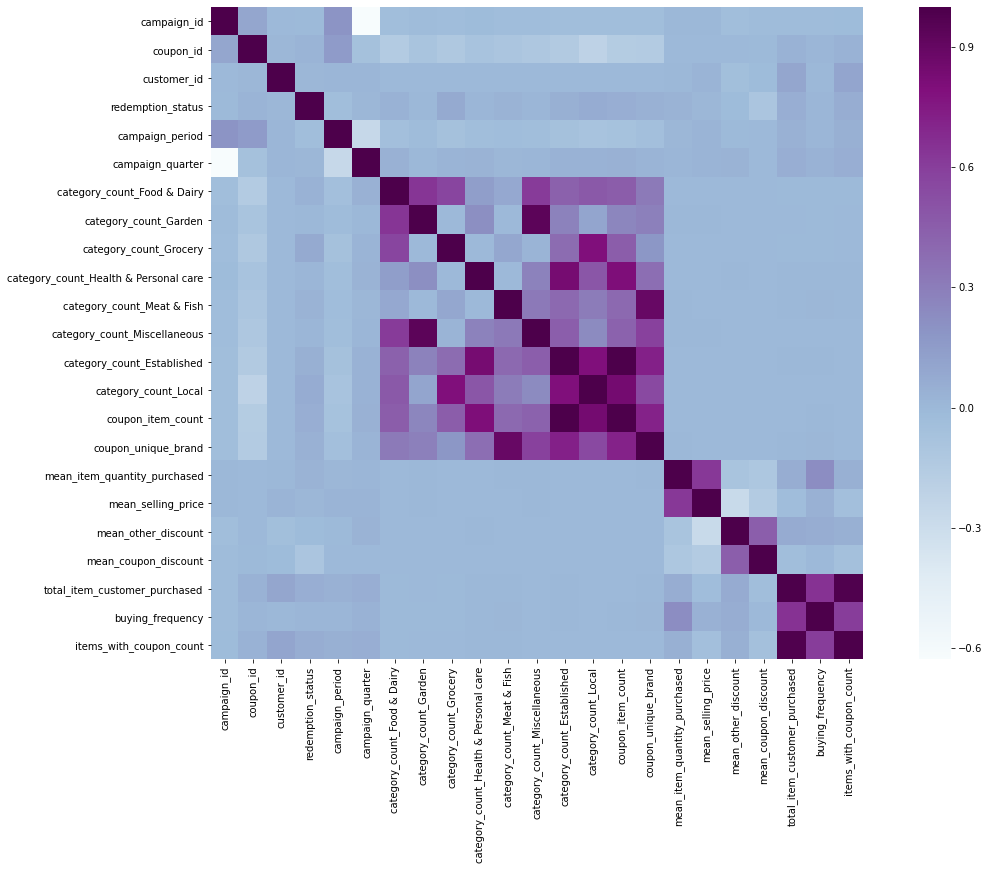

In [141]:
plt.figure(figsize=(20,12))
sns.heatmap(df_final.corr(),square=True,cmap="BuPu")
plt.show()

### Encoding

In [142]:
df_final.drop(["start_date","end_date"],axis=1,inplace=True)

In [143]:
df_final=pd.get_dummies(df_final,columns=["campaign_type","campaign_Year","campaign_month"],drop_first=True)
df_final.head()

,campaign_id,coupon_id,customer_id,redemption_status,campaign_period,campaign_quarter,category_count_Food & Dairy,category_count_Garden,category_count_Grocery,category_count_Health & Personal care,category_count_Meat & Fish,category_count_Miscellaneous,category_count_Established,category_count_Local,coupon_item_count,coupon_unique_brand,mean_item_quantity_purchased,mean_selling_price,mean_other_discount,mean_coupon_discount,total_item_customer_purchased,buying_frequency,items_with_coupon_count,campaign_type_Y,campaign_Year_2013,campaign_month_2,campaign_month_4,campaign_month_5,campaign_month_7,campaign_month_8,campaign_month_9,campaign_month_11,campaign_month_12
0,13,27,1053,0,12,6,0.000000,0.000000,125.000000,0.000000,0.000000,0.000000,125.000000,0.000000,125,2,340.000000,184.260484,-33.168935,-0.287258,310,80,139,0,1,0,0,1,0,0,0,0,0
1,13,116,48,0,12,6,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3,1,32.000000,234.247013,-27.699169,-3.215039,385,64,210,0,1,0,0,1,0,0,0,0,0
2,9,635,205,0,31,8,0.000000,0.000000,0.000000,67.000000,0.000000,0.000000,67.000000,0.000000,67,1,1.000000,121.094495,-17.795660,-2.212082,970,83,652,1,1,0,0,0,0,0,0,1,0
3,13,644,1050,0,12,6,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,4.000000,0.000000,4,1,1.000000,98.276034,-16.655570,-0.751477,237,64,128,0,1,0,0,1,0,0,0,0,0
4,8,1017,1489,0,77,5,0.000000,0.000000,32.000000,0.000000,0.000000,0.000000,32.000000,0.000000,32,1,247.000000,120.636103,-20.524733,-0.471548,562,97,283,0,1,1,0,0,0,0,0,0,0


In [144]:
df_final.shape

(78369, 33)

In [145]:
df_final.columns

Index(['campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'campaign_period', 'campaign_quarter', 'category_count_Food & Dairy',
       'category_count_Garden', 'category_count_Grocery',
       'category_count_Health & Personal care', 'category_count_Meat & Fish',
       'category_count_Miscellaneous', 'category_count_Established',
       'category_count_Local', 'coupon_item_count', 'coupon_unique_brand',
       'mean_item_quantity_purchased', 'mean_selling_price',
       'mean_other_discount', 'mean_coupon_discount',
       'total_item_customer_purchased', 'buying_frequency',
       'items_with_coupon_count', 'campaign_type_Y', 'campaign_Year_2013',
       'campaign_month_2', 'campaign_month_4', 'campaign_month_5',
       'campaign_month_7', 'campaign_month_8', 'campaign_month_9',
       'campaign_month_11', 'campaign_month_12'],
      dtype='object')

### Outlier 

In [146]:
num_list=['campaign_period','campaign_quarter','coupon_item_count','coupon_unique_brand','mean_item_quantity_purchased', 'mean_selling_price',
       'mean_other_discount', 'mean_coupon_discount','total_item_customer_purchased', 'buying_frequency','items_with_coupon_count']

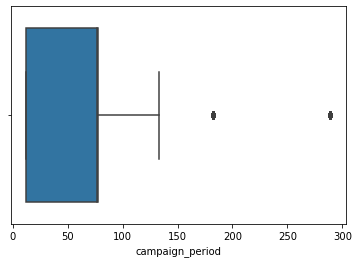

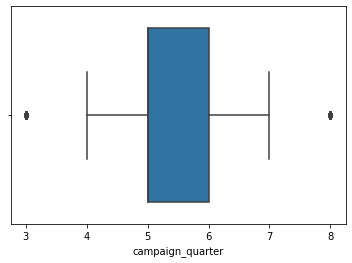

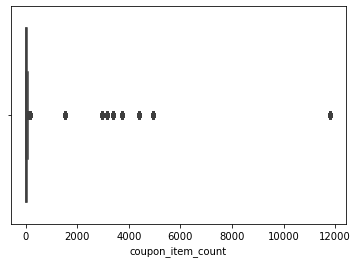

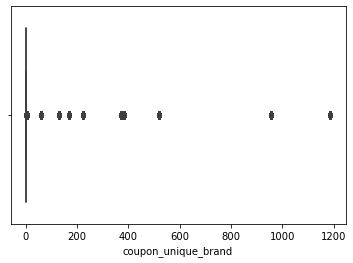

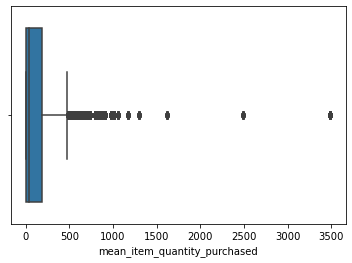

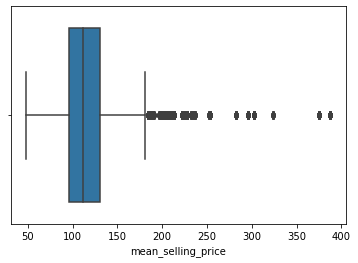

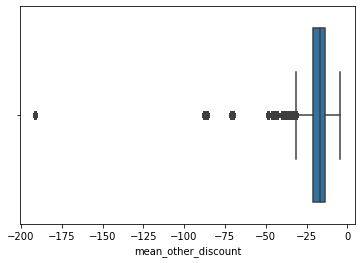

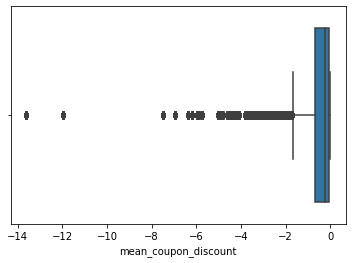

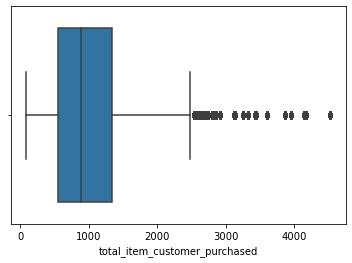

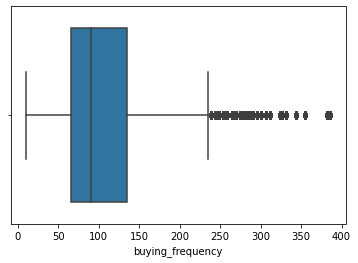

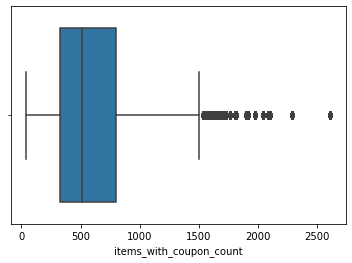

In [147]:
for i in num_list:
    sns.boxplot(df_final[i])
    plt.show()

### Data Distribution

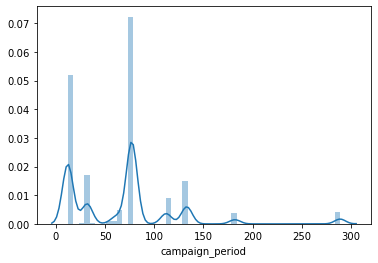

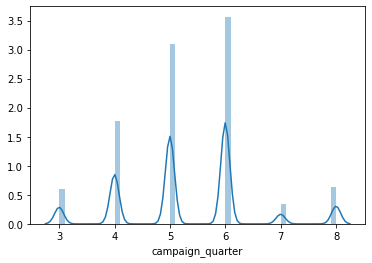

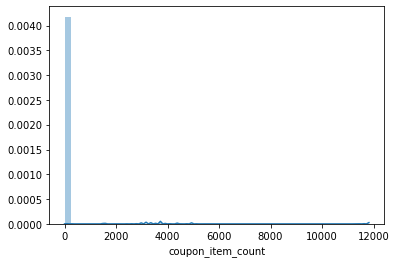

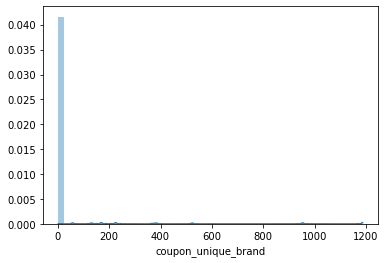

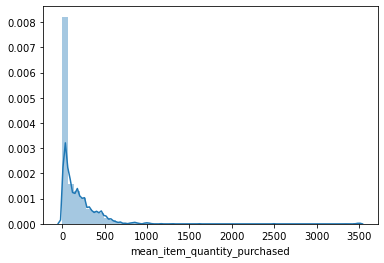

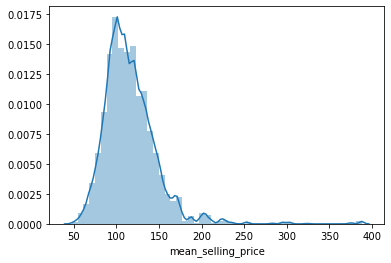

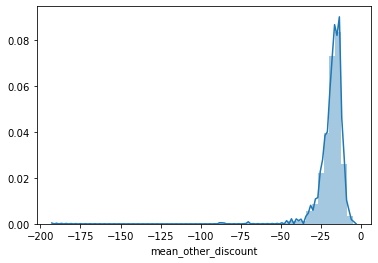

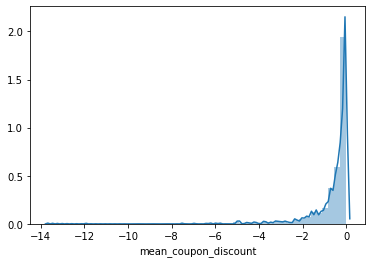

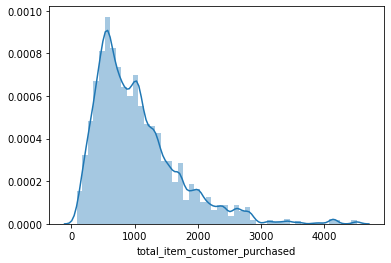

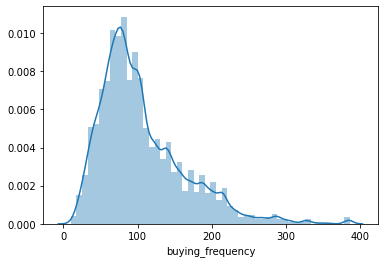

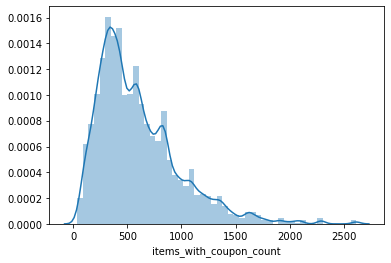

In [148]:
for i in num_list:
    sns.distplot(df_final[i])
    plt.show()

### Model

In [149]:
x= df_final.drop("redemption_status",axis=1)
y=df_final["redemption_status"]

In [150]:
rf=RandomForestClassifier()

In [151]:
cv=cross_val_score(rf,x,y,cv=5,scoring="roc_auc")

In [152]:
cv

array([0.87255722, 0.87651207, 0.87106919, 0.88165766, 0.84709357])

In [153]:
cv.mean()

0.8697779414796001

In [154]:
1-cv.mean()

0.13022205852039992

In [155]:
np.std(cv,ddof=1)

0.013327120727352102

In [297]:
df_final.head()

,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,campaign_period,campaign_Year,campaign_month,campaign_quarter,category_count_Food & Dairy,category_count_Garden,category_count_Grocery,category_count_Health & Personal care,category_count_Meat & Fish,category_count_Miscellaneous,category_count_Established,category_count_Local,coupon_item_count,coupon_unique_brand,mean_item_quantity_purchased,mean_selling_price,mean_other_discount,mean_coupon_discount,total_item_customer_purchased,buying_frequency,items_with_coupon_count
0,13,27,1053,0,X,2013-05-19,2013-05-07,12,2013,5,6,0.000000,0.000000,125.000000,0.000000,0.000000,0.000000,125.000000,0.000000,125,2,340.000000,184.260484,-33.168935,-0.287258,310,80,139
1,13,116,48,0,X,2013-05-19,2013-05-07,12,2013,5,6,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3,1,32.000000,234.247013,-27.699169,-3.215039,385,64,210
2,9,635,205,0,Y,2013-11-03,2013-12-04,31,2013,11,8,0.000000,0.000000,0.000000,67.000000,0.000000,0.000000,67.000000,0.000000,67,1,1.000000,121.094495,-17.795660,-2.212082,970,83,652
3,13,644,1050,0,X,2013-05-19,2013-05-07,12,2013,5,6,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,4.000000,0.000000,4,1,1.000000,98.276034,-16.655570,-0.751477,237,64,128
4,8,1017,1489,0,X,2013-02-16,2013-05-04,77,2013,2,5,0.000000,0.000000,32.000000,0.000000,0.000000,0.000000,32.000000,0.000000,32,1,247.000000,120.636103,-20.524733,-0.471548,562,97,283


In [301]:
df_final.shape

(78369, 28)

In [298]:
df_final.columns

Index(['campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'campaign_type', 'start_date', 'end_date', 'campaign_period',
       'campaign_Year', 'campaign_month', 'campaign_quarter',
       'category_count_Food & Dairy', 'category_count_Garden',
       'category_count_Grocery', 'category_count_Health & Personal care',
       'category_count_Meat & Fish', 'category_count_Miscellaneous',
       'category_count_Established', 'category_count_Local',
       'coupon_item_count', 'coupon_unique_brand',
       'mean_item_quantity_purchased', 'mean_selling_price',
       'mean_other_discount', 'mean_coupon_discount',
       'total_item_customer_purchased', 'buying_frequency',
       'items_with_coupon_count'],
      dtype='object')